Description Here.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import MultipleLocator, FuncFormatter
from math import sqrt, cosh, cos, sinh, sin, pi, exp
import time

import capytaine as cpt
from capytaine_generator import CapytaineSlantSolver

import sys
import os
sys.path.append(os.path.relpath('../'))
from multi_condensed import Problem

# removes capytaine warnings from clogging outputs
import logging
logging.getLogger("capytaine").setLevel(logging.ERROR)

import pickle

In [2]:
def update_data_file(data, name):
  with open(name, "wb") as f:
    pickle.dump(data, f)

def load_data(name):
  with open(name, "rb") as f:
    data = pickle.load(f)
  return data

In [3]:
# Generate the configurations: Matching most variables with the ps3 stuff.

h = 100
m0 = 0.9
rho = 1023
numerators = list(range(1, 8)) + list(range(8, 16, 2)) + list(range(16, 32, 4))
# configurations = []

# for num in numerators:
#   theta = np.pi * num / 64
#   d1 = (1/np.tan(theta) * 4) + 5
#   configurations.append({"name" : "config-t-" + str(num) +"pi-64",
#                         "h" : h,
#                         "a" : [3, 7],
#                         "theta" : theta,
#                         "d_in" : [d1, d1],
#                         "d_out" : [d1, 5], 
#                         "heaving" : [0, 1],
#                         "m0" : m0, 
#                         "rho" : rho})
  
configurations = load_data("data/ps6.pkl")

In [4]:
# Modified MEEM Problem for slants
class SProblem1(Problem):
    def __init__(self, h, d, a, heaving, NMK, m0, rho, slopes, scale = None):
        self.h = h
        self.d = d
        self.a = a
        self.heaving = heaving
        self.NMK = NMK
        self.m0 = m0
        self.rho = rho
        self.scale = a if scale is None else scale
        self.size = NMK[0] + NMK[-1] + 2 * sum(NMK[1:len(NMK) - 1])
        self.boundary_count = len(NMK) - 1
        self.m_k = self.m_k_array()
        self.slopes = slopes
        self.thetas = self.get_angles()
    
    def get_angles(self):
        def arccot(x):
            if x == 0: return np.pi/2
            else: return np.atan(1/x)
        return [arccot(slope) for slope in self.slopes]

    def det_region(self, r):
        region = 0
        for i in range(self.boundary_count):
            if r <= self.a[i]:
                return region
            else: region += 1
        return region
    
    # No change in potential matching, alterations are all to velocity matching.
    def b_velocity_entry(self, n, i): # for two i-type regions
        h, d, a, heaving = self.h, self.d, self.a, self.heaving
        if n == 0:
            return (heaving[i+1] - heaving[i]) * (a[i]/2)
        if d[i] > d[i + 1]: #using i+1's vertical eigenvectors
            if heaving[i]:
                num = - sqrt(2) * a[i] * sin(self.lambda_ni(n, i+1) * (h-d[i]))
                denom = (2 * (h - d[i]) * self.lambda_ni(n, i+1))
                base =  num/denom
            else: base = 0
            if heaving[i + 1] and self.slopes[i + 1] != 0:
                lambda0 = self.lambda_ni(n, i + 1)
                t1 = sin(lambda0 * (h - d[i])) / lambda0
                t2_top = ((-1) ** n)/((h - d[i + 1]) * lambda0 **2)
                t2_bot = (cos(lambda0 * (h - d[i]))/(lambda0**2) + (h - d[i]) * sin(lambda0 * (h - d[i]))/lambda0)/(h - d[i + 1])
                correction = sqrt(2) * (1/self.slopes[i + 1]) * (t1 + t2_top - t2_bot)
            else: correction = 0
            return base + correction
        else: #using i's vertical eigenvectors
            if heaving[i+1]:
                num = sqrt(2) * a[i] * sin(self.lambda_ni(n, i) * (h-d[i+1]))
                denom = (2 * (h - d[i+1]) * self.lambda_ni(n, i))
                base = num/denom
            else: base = 0
            if heaving[i] and self.slopes[i] != 0:
                lambda0 = self.lambda_ni(n, i)
                t1 = sin(lambda0 * (h - d[i + 1])) / lambda0
                t2_top = ((-1) ** n)/((h - d[i]) * lambda0 **2)
                t2_bot = (cos(lambda0 * (h - d[i + 1]))/(lambda0**2) + (h - d[i+1]) * sin(lambda0 * (h - d[i+1]))/lambda0)/(h - d[i])
                correction = - sqrt(2) * (1/self.slopes[i]) * (t1 + t2_top - t2_bot)
            else: correction = 0
            return base + correction
    # no modification for end entry
    # Alterations to A matrix: None to potential, many to velocity
    def a_matrix_correction(self, i, j, n, m): # i = region #, j = adjacent region #
        if self.slopes[i] == 0: return 0
        if n == 0: return 0
        d1 = self.d[j]
        # d2 = self.d[i]
        h = self.h
        lambda_n = self.lambda_ni(n, i)
        if m == 0:
            prefactor = sqrt(2) * (1/self.slopes[i])
            t_d1 = - cos(lambda_n * (h - d1))
            t_d2 = - (-1) ** n
            return prefactor * (t_d2 - t_d1)
        lambda_m = self.lambda_ni(m, i)
        prefactor = 2 * (1/self.slopes[i]) * lambda_n
        if m == n:
            t_d1 = - (cos(lambda_m * (h - d1)) ** 2) / (2 * lambda_m)
            t_d2 = - 1 / (2 * lambda_m)
            return prefactor * (t_d2 - t_d1)
        else: # m != n
            t_d1 = (1/2) * (cos((lambda_m - lambda_n) * (h - d1))/(lambda_m - lambda_n) - cos((lambda_m + lambda_n) * (h - d1))/(lambda_m + lambda_n))
            t_d2 = (1/2) * ((-1)**(m-n)/(lambda_m - lambda_n) - (-1)**(m+n)/(lambda_m + lambda_n))
            return prefactor * (t_d2 - t_d1)
        
    def v_diagonal_block(self, left, radfunction, radfunction_corr, bd):
        h, d, a, NMK = self.h, self.d, self.a, self.NMK
        region = bd if left else (bd + 1)
        adj = bd + 1 if left else bd
        sign = (-1) if left else (1)
        diag_block = (h - d[region]) * np.diag(radfunction(list(range(NMK[region])), a[bd], region))
        radial_vector = radfunction_corr(list(range(NMK[region])), a[bd], region)
        radial_array = np.outer((np.full((NMK[region]), 1)), radial_vector)
        m, n = np.indices((NMK[region], NMK[region]))
        correction = np.vectorize(self.a_matrix_correction)(region, adj, n, m)
        corr_block = correction * radial_array
        return sign * (diag_block + corr_block)
    
    #############################################
    # A matrix calculations
    def a_matrix(self):
        d, NMK, boundary_count, size = self.d, self.NMK, self.boundary_count, self.size
        # localize eigenfunctions
        R_1n, R_2n, diff_R_1n, diff_R_2n = self.R_1n, self.R_2n, self.diff_R_1n, self.diff_R_2n
        # localize block functions
        p_diagonal_block = self.p_diagonal_block
        p_dense_block, p_dense_block_e = self.p_dense_block, self.p_dense_block_e
        v_diagonal_block, v_diagonal_block_e = self.v_diagonal_block, self.v_diagonal_block_e
        v_dense_block, v_dense_block_e = self.v_dense_block, self.v_dense_block_e

        # compute the coupling integrals and store values
        I_nm_vals = self.I_nm_vals()
        I_mk_vals = self.I_mk_vals()

        rows = [] # collection of rows of blocks in A matrix, to be concatenated later

        # Potential Blocks
        col = 0
        for bd in range(boundary_count):
            N = NMK[bd]
            M = NMK[bd + 1]
            if bd == (boundary_count - 1): # i-e boundary, inherently left diagonal
                row_height = N
                left_block1 = p_diagonal_block(True, np.vectorize(R_1n), bd)
                right_block = p_dense_block_e(bd, I_mk_vals)
                if bd == 0: # one cylinder
                    rows.append(np.concatenate((left_block1,right_block), axis = 1))
                else:
                    left_block2 = p_diagonal_block(True, np.vectorize(R_2n), bd)
                    left_zeros = np.zeros((row_height, col), dtype=complex)
                    rows.append(np.concatenate((left_zeros,left_block1,left_block2,right_block), axis = 1))
            elif bd == 0:
                left_diag = d[bd] > d[bd + 1] # which of the two regions gets diagonal entries
                if left_diag:
                    row_height = N
                    left_block = p_diagonal_block(True, np.vectorize(R_1n), 0)
                    right_block1 = p_dense_block(False, np.vectorize(R_1n), 0, I_nm_vals)
                    right_block2 = p_dense_block(False, np.vectorize(R_2n), 0, I_nm_vals)
                else:
                    row_height = M
                    left_block = p_dense_block(True, np.vectorize(R_1n), 0, I_nm_vals)
                    right_block1 = p_diagonal_block(False, np.vectorize(R_1n), 0)
                    right_block2 = p_diagonal_block(False, np.vectorize(R_2n), 0)
                right_zeros = np.zeros((row_height, size - (col + N + 2 * M)),dtype=complex)
                block_lst = [left_block, right_block1, right_block2, right_zeros]
                rows.append(np.concatenate(block_lst, axis = 1))
                col += N
            else: # i-i boundary
                left_diag = d[bd] > d[bd + 1] # which of the two regions gets diagonal entries
                if left_diag:
                    row_height = N
                    left_block1 = p_diagonal_block(True, np.vectorize(R_1n), bd)
                    left_block2 = p_diagonal_block(True, np.vectorize(R_2n), bd)
                    right_block1 = p_dense_block(False, np.vectorize(R_1n),  bd, I_nm_vals)
                    right_block2 = p_dense_block(False, np.vectorize(R_2n),  bd, I_nm_vals)
                else:
                    row_height = M
                    left_block1 = p_dense_block(True, np.vectorize(R_1n),  bd, I_nm_vals)
                    left_block2 = p_dense_block(True, np.vectorize(R_2n),  bd, I_nm_vals)
                    right_block1 = p_diagonal_block(False, np.vectorize(R_1n),  bd)
                    right_block2 = p_diagonal_block(False, np.vectorize(R_2n),  bd)
                left_zeros = np.zeros((row_height, col), dtype=complex)
                right_zeros = np.zeros((row_height, size - (col + 2 * N + 2 * M)),dtype=complex)
                block_lst = [left_zeros, left_block1, left_block2, right_block1, right_block2, right_zeros]
                rows.append(np.concatenate(block_lst, axis = 1))
                col += 2 * N

        # Velocity Blocks
        col = 0
        for bd in range(boundary_count):
            N = NMK[bd]
            M = NMK[bd + 1]
            if bd == (boundary_count - 1): # i-e boundary, inherently left diagonal
                row_height = M
                left_block1 = v_dense_block_e(np.vectorize(diff_R_1n, otypes=[complex]), bd, I_mk_vals)
                right_block = v_diagonal_block_e(bd)
                if bd == 0: # one cylinder
                    rows.append(np.concatenate((left_block1,right_block), axis = 1))
                else:
                    left_block2 = v_dense_block_e(np.vectorize(diff_R_2n, otypes=[complex]), bd, I_mk_vals)
                    left_zeros = np.zeros((row_height, col), dtype=complex)
                    rows.append(np.concatenate((left_zeros,left_block1,left_block2,right_block), axis = 1))
            elif bd == 0:
                left_diag = d[bd] <= d[bd + 1] # taller fluid region gets diagonal entries
                if left_diag:
                    row_height = N
                    left_block = v_diagonal_block(True, np.vectorize(diff_R_1n, otypes=[complex]), np.vectorize(R_1n, otypes=[complex]), 0)
                    right_block1 = v_dense_block(False, np.vectorize(diff_R_1n, otypes=[complex]), 0, I_nm_vals)
                    right_block2 = v_dense_block(False, np.vectorize(diff_R_2n, otypes=[complex]), 0, I_nm_vals)
                else:
                    row_height = M
                    left_block = v_dense_block(True, np.vectorize(diff_R_1n, otypes=[complex]), 0, I_nm_vals)
                    right_block1 = v_diagonal_block(False, np.vectorize(diff_R_1n, otypes=[complex]), np.vectorize(R_1n, otypes=[complex]),0)
                    right_block2 = v_diagonal_block(False, np.vectorize(diff_R_2n, otypes=[complex]), np.vectorize(R_2n, otypes=[complex]),0)
                right_zeros = np.zeros((row_height, size - (col + N + 2 * M)),dtype=complex)
                block_lst = [left_block, right_block1, right_block2, right_zeros]
                rows.append(np.concatenate(block_lst, axis = 1))
                col += N
            else: # i-i boundary
                left_diag = d[bd] <= d[bd + 1] # taller fluid region gets diagonal entries
                if left_diag:
                    row_height = N
                    left_block1 = v_diagonal_block(True, np.vectorize(diff_R_1n, otypes=[complex]), np.vectorize(R_1n, otypes=[complex]), bd)
                    left_block2 = v_diagonal_block(True, np.vectorize(diff_R_2n, otypes=[complex]), np.vectorize(R_2n, otypes=[complex]), bd)
                    right_block1 = v_dense_block(False, np.vectorize(diff_R_1n, otypes=[complex]),  bd, I_nm_vals)
                    right_block2 = v_dense_block(False, np.vectorize(diff_R_2n, otypes=[complex]),  bd, I_nm_vals)
                else:
                    row_height = M
                    left_block1 = v_dense_block(True, np.vectorize(diff_R_1n, otypes=[complex]),  bd, I_nm_vals)
                    left_block2 = v_dense_block(True, np.vectorize(diff_R_2n, otypes=[complex]),  bd, I_nm_vals)
                    right_block1 = v_diagonal_block(False, np.vectorize(diff_R_1n, otypes=[complex]), np.vectorize(R_1n, otypes=[complex]), bd)
                    right_block2 = v_diagonal_block(False, np.vectorize(diff_R_2n, otypes=[complex]), np.vectorize(R_2n, otypes=[complex]), bd)
                left_zeros = np.zeros((row_height, col), dtype=complex)
                right_zeros = np.zeros((row_height, size - (col + 2* N + 2 * M)),dtype=complex)
                block_lst = [left_zeros, left_block1, left_block2, right_block1, right_block2, right_zeros]
                rows.append(np.concatenate(block_lst, axis = 1))
                col += 2 * N

        ## Concatenate the rows of blocks into the square A matrix
        return np.concatenate(rows, axis = 0)

    def phi_p_i(self, r, z, i): # particular solution
        return (1 / (2* (self.h - self.d[i]))) * ((z + self.h) ** 2 - (r**2) / 2)
    
    def potential(self, r, z, cs): # at a point
      region = self.det_region(r)
      nmk = self.NMK[region]
      nmks = list(range(nmk))
      if region == self.boundary_count: # Outermost
        lambda_vals = np.vectorize(self.Lambda_k, otypes=[complex])(nmks, r)
        z_vals = np.vectorize(self.Z_k_e, otypes=[complex])(nmks, z)
        return np.dot(cs[-1], lambda_vals * z_vals)
      else:
        phi_p = 0 if not self.heaving[region] else self.phi_p_i(r, z, region)
        r1_vals = np.vectorize(self.R_1n, otypes=[complex])(nmks, r, region)
        z_vals = np.vectorize(self.Z_n_i, otypes=[complex])(nmks, z, region)
        phi_h_1 = np.dot(cs[region][:nmk], r1_vals * z_vals)
        if region == 0: # Innermost
          return phi_p + phi_h_1
        else: # Typical region
          r2_vals = np.vectorize(self.R_2n, otypes=[complex])(nmks, r, region)
          phi_h_2 = np.dot(cs[region][nmk:], r2_vals * z_vals)
          return phi_p + phi_h_1 + phi_h_2
      
    def regional_value(self, i, cs, outline_function, frac1, frac2 = None):
      inner_rad = 0 if i == 0 else self.a[i - 1]
      outer_rad = self.a[i]
      rad1 = frac1 * (outer_rad - inner_rad) + inner_rad
      p1 = self.potential(rad1, outline_function(rad1), cs)
      if frac2 is None:
        return p1 * (outer_rad **2 - inner_rad **2)/2
      else:
        rad2 = frac2 * (outer_rad - inner_rad) + inner_rad
        p2 = self.potential(rad2, outline_function(rad2), cs)
        mid_rad = inner_rad + (outer_rad - inner_rad)/2
        v1 = p1 * (mid_rad **2 - inner_rad **2)/2
        v2 = p2 * (outer_rad **2 - mid_rad **2)/2
        return v1 + v2

    # Compute hydro-coefficients by approximating potential on each surface as equal the potential at a specific point
    # a fraction of the way along that surface
    def hydros_by_averages(self, cs, outline_function, convention, frac1 = 0.25, frac2 = None):
      accumulator = 0
      for region in range(self.boundary_count):
        if self.heaving[region]:
          if self.slopes[region] == 0: # typical calculation
            nmk = self.NMK[region]
            r1 = np.dot([self.int_R_1n(region, m)* self.z_n_d(m) for m in range(nmk)], cs[region][:nmk])
            if region == 0:
              accumulator += (r1 + self.int_phi_p_i(region))
            else:
              r2 = np.dot([self.int_R_2n(region, m)* self.z_n_d(m) for m in range(nmk)], cs[region][nmk:])
              accumulator += (r1 + r2 + self.int_phi_p_i(region))
          else:
            accumulator += self.regional_value(region, cs, outline_function, frac1, frac2)

      hydro_coef = 2 * pi * accumulator
      if convention == "nondimensional":
          # find maximum heaving radius
          max_rad = self.a[0]
          for i in range(self.boundary_count - 1, 0, -1):
              if self.heaving[i]:
                  max_rad = self.a[i]
                  break
          hydro_coef_nondim = self.h**3/(max_rad**3 * pi)*hydro_coef
          added_mass = hydro_coef_nondim.real
          damping = hydro_coef_nondim.imag
      elif convention == "umerc":
          added_mass = hydro_coef.real * self.h**3 * self.rho
          damping = hydro_coef.imag * self.angular_freq(self.m0) * self.h**3 * self.rho
      elif convention == "capytaine":
          added_mass = hydro_coef.real * self.rho
          damping = hydro_coef.imag * self.angular_freq(self.m0) * self.rho
      else:
          raise ValueError("Allowed conventions are nondimensional, umerc, and capytaine.")
      return added_mass, damping

In [5]:
# MEEM-solving functions
# staircase with outline on exterior corners
def make_slant_region1(d1, d2, a1, a2, res): # Probably works best for modified MEEM
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (offset + i) * delta_d)
  return a_prime, d_prime

# staircase with outlines through centers, starting horizontal, end vertical
def make_slant_region2(d1, d2, a1, a2, res): # Empirically worked best for regular MEEM
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  # offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (0.5 + i) * delta_a)
     d_prime.append(d1 + (i) * delta_d)
  a_prime.append(a2)
  d_prime.append(d2)
  return a_prime, d_prime

def slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version):
  if version == 1:
     make_slant_region = make_slant_region1
  elif version == 2:
     make_slant_region = make_slant_region2
  else:
     raise ValueError
  
  a_prime = []
  d_prime = []
  heaving_prime = []
  NMK_prime = []
  slopes = []
  for i in range(len(a)):
    if d_in[i] == d_out[i]: # horizontal region
        a_prime.append(a[i])
        d_prime.append(d_in[i])
        heaving_prime.append(heaving[i])
        NMK_prime.append(NMK[i])
        slopes.append(0)
    else: # slanted region
       heaving_prime += ([heaving[i]] * res)
       NMK_prime += ([NMK[i]] * res)
       a_inner = 0 if i == 0 else a[i - 1]
       a_add, d_add = make_slant_region(d_in[i], d_out[i], a_inner, a[i], res)
       a_prime += a_add
       d_prime += d_add
       slope = (d_in[i]-d_out[i])/(a[i] - a[i - 1]) # better edit needed for sloped innermost region
       slopes += ([slope] * res)
  NMK_prime.append(NMK[-1])
  return d_prime, a_prime, heaving_prime, NMK_prime, slopes

def solve_problem(prob_style, config, res, version, nmk = 150):
  h, a, d_in, d_out, heaving, m0, rho = config["h"], config["a"], config["d_in"], config["d_out"], config["heaving"], config["m0"], config["rho"]
  NMK = [nmk, nmk, nmk]
  d_prime, a_prime, heaving_prime, NMK_prime, slopes = slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version)
  if prob_style == Problem:
     prob = prob_style(h, d_prime, a_prime, heaving_prime, NMK_prime, m0, rho)
  else:
     prob = prob_style(h, d_prime, a_prime, heaving_prime, NMK_prime, m0, rho, slopes)
  a_matrix = prob.a_matrix()
  b_vector = prob.b_vector()
  x = prob.get_unknown_coeffs(a_matrix, b_vector)
  cs = prob.reformat_coeffs(x)
  return x, cs, prob

def solve_box_MEEM(config, nmk = 150):
   h, d, a, heaving, m0, rho = config["h"], config["d_out"], config["a"], config["heaving"], config["m0"], config["rho"]
   NMK = [nmk, nmk, nmk]
   prob = Problem(h, d, a, heaving, NMK, m0, rho)
   a_matrix = prob.a_matrix()
   b_vector = prob.b_vector()
   x = prob.get_unknown_coeffs(a_matrix, b_vector)
   am, dp = prob.hydro_coeffs(x, "capytaine")
   return am, dp

In [6]:
# Capytaine-Solving Functions

css = CapytaineSlantSolver(False, False, False, False, False)

def compute_cpt_slant(config):
  t_densities = [30, 60]
  f_densities = [15, 140, 15]
  respack = css.construct_and_solve(config["a"], config["d_in"], config["d_out"], config["heaving"], t_densities, 150, config["h"], config["m0"], config["rho"], 1, f_densities)
  am, dp = (respack[0].added_mass)["Heave"], (respack[0].radiation_damping)["Heave"]
  return am, dp

# def compute_cpt_box(config):
#   t_densities = [30, 60]
#   f_densities = [15, 140, 15]
#   respack = css.construct_and_solve(config["a"], config["d_out"], config["d_out"], config["heaving"], t_densities, 150, config["h"], config["m0"], config["rho"], 1, f_densities)
#   am, dp = (respack[0].added_mass)["Heave"], (respack[0].radiation_damping)["Heave"]
#   return am, dp

In [61]:
# for each configuration:
# 1. get the capytaine slant values
# 2. box-configuration convergence study
# 3. run MEEM-solver for regular MEEM and slant MEEM, convergence wrt different values

def get_capytaine_data(config, configurations):
  am, dp = compute_cpt_slant(config)
  config["CPT slant AM"] = am
  config["CPT slant DP"] = dp
  update_data_file(configurations, "data/ps6.pkl")
  print("Finished " + config["name"] + "CPT slant computations.")

def box_MEEM_convergence(config, configurations):
  nmks = range(10, 301, 10)
  ams = []
  dps = []
  for nmk in nmks:
    am, dp = solve_box_MEEM(config, nmk = nmk)
    ams.append(am)
    dps.append(dp)
  config["MEEM box AMs"], config["MEEM box DPs"] = ams, dps
  update_data_file(configurations, "data/ps6.pkl")
  print("Finished " + config["name"] + "MEEM box computations.")

def make_outline(config):
  a, d_in, d_out = config["a"], config["d_in"], config["d_out"]
  def outline_function(r):
    region = 0
    for rad in a:
      if r <= rad: break
      else: region += 1
    if region == len(a): return 0
    elif d_in[region] == d_out[region]:
      return - d_in[region]
    else:
      inner_rad = 0 if region == 0 else a[region - 1]
      outer_rad = a[region]
      slope = (d_in[region] - d_out[region])/(outer_rad - inner_rad)
      return slope * (r - inner_rad) - d_in[region]
  return outline_function

def vary_res(config, configurations, prob_style):
  nmk = 150
  resolutions = list(range(5, 51, 5))
  ams = []
  dps = []
  if prob_style == Problem:
    for res in resolutions:
      x, cs, prob = solve_problem(prob_style, config, res, 2, nmk = nmk)
      am, dp = prob.hydro_coeffs(x, "capytaine")
      ams.append(am)
      dps.append(dp)
    config["res MEEM regular AMs"], config["res MEEM regular DPs"] = ams, dps
  else:
    outline_function = make_outline(config)
    for res in resolutions:
      x, cs, prob = solve_problem(prob_style, config, res, 1, nmk = nmk)
      am_lst, dp_lst = [], []
      for frac1 in [entry / 20 for entry in range(1, 20)]:
        am, dp = prob.hydros_by_averages(cs, outline_function, "capytaine", frac1)
        am_lst.append(am)
        dp_lst.append(dp)
      ams.append(am_lst)
      dps.append(dp_lst)
    config["res MEEM modded AMs"], config["res MEEM modded DPs"] = ams, dps
  update_data_file(configurations, "data/ps6.pkl")
  print("Finished " + config["name"] + " res computations.")

def vary_nmk(config, configurations, prob_style):
  res = 30
  nmks = list(range(25, 251, 25))
  ams = []
  dps = []
  if prob_style == Problem:
    for nmk in nmks:
      x, cs, prob = solve_problem(prob_style, config, res, 2, nmk = nmk)
      am, dp = prob.hydro_coeffs(x, "capytaine")
      ams.append(am)
      dps.append(dp)
    config["nmk MEEM regular AMs"], config["nmk MEEM regular DPs"] = ams, dps
  else:
    outline_function = make_outline(config)
    for nmk in nmks:
      x, cs, prob = solve_problem(prob_style, config, res, 1, nmk = nmk)
      am_lst, dp_lst = [], []
      for frac1 in [entry / 20 for entry in range(1, 20)]:
        am, dp = prob.hydros_by_averages(cs, outline_function, "capytaine", frac1)
        am_lst.append(am)
        dp_lst.append(dp)
      ams.append(am_lst)
      dps.append(dp_lst)
    config["nmk MEEM modded AMs"], config["nmk MEEM modded DPs"] = ams, dps
  update_data_file(configurations, "data/ps6.pkl")
  print("Finished " + config["name"] + " nmk computations.")

In [63]:
# for config in configurations:
#   # Solve Capytaine Slant
#   get_capytaine_data(config, configurations)
#   # Convergence study for box-MEEM
  # box_MEEM_convergence(config, configurations)
#   # Vary res for regular MEEM
#   vary_res(config, configurations, Problem)
#   # Vary res for modded MEEM
#   vary_res(config, configurations, SProblem1)
#   # Vary nmk for regular MEEM
#   vary_nmk(config, configurations, Problem)
#   # Vary nmk for modded MEEM
#   vary_nmk(config, configurations, SProblem1)

In [30]:
def plot_multiple_fade(x, ys, colors = ["Reds", "Greens", "Blues"], labs = None, last_k = None, title = "plot", xlab = "x", ylab = "y", hline = None, hlab = None):
    if hline is not None:
      plt.axhline(y = hline, color='orange', label = hlab)

    if type(ys[0][0]) != list:
       ys = [ys]

    if labs is None or type(labs[0]) != list:
       labs = [labs]

    for i in range(len(ys)):
      plot_fade(x, ys[i], labs[i], last_k, colors[i])

    if xlab == "theta":
      ax = plt.gca()
      ax.xaxis.set_major_locator(MultipleLocator(np.pi / 8))
      ax.xaxis.set_major_formatter(FuncFormatter(format_func))

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_fade(x, ys, labs = None, last_k = None, cname = "Blue"):
  if labs is None:
      labs = [None] * len(ys)

  if last_k is not None: # get rid of early extreme values for scaling
      x = x[-last_k:]
      ys = [y[-last_k:] for y in ys]

  cmap = get_cmap(cname)
  color_vals = np.linspace(0.8, 0.2, len(ys))

  for y, label, color_val in zip(ys, labs, color_vals):
        plt.plot(x, y, label = label, color=cmap(color_val))

def format_func(value, tick_number):
    frac = 1 / 16
    multiple = round(value / (np.pi * frac))
    num = multiple
    denom = int(1 / frac)

    if multiple == 0:
        return "0"

    # Reduce the fraction
    common = np.gcd(abs(num), denom)
    num //= common
    denom //= common

    if denom == 1:
        coeff = f"{num}" if abs(num) != 1 else ("-" if num == -1 else "")
        return rf"${coeff}\pi$"
    else:
        coeff = "-" if num < 0 else ""
        num_string = "" if abs(num) == 1 else abs(num)
        return rf"${coeff}\frac{{{num_string}\pi}}{{{denom}}}$"
    
def make_label(num_lst, key):
  return [key + " = " + str(num) for num in num_lst]

def extract(configurations, key, length = None):
  if type(configurations[0][key]) != list:
     return [config[key] for config in configurations]
  if length is None:
     length = len(configurations[0][key])
  all_series = []
  for i in range(length):
    single_series = [config[key][i] for config in configurations]
    all_series.append(single_series)
  return all_series

def lists_shape(lst):
  output = ""
  while True:
      if type(lst) == list:
         output = output + str(len(lst)) + " "
         lst = lst[0]
      else:
         break
  print(output)

def list_ratios(lst_of_lsts, base_lst):
  # Element i of each list  is expressed as a ratio to the the ith entry of base_lst
  output = []
  for lst in lst_of_lsts:
    output.append([lst[i]/base_lst[i] for i in range(len(base_lst))])
  return output

def transpose(matrix):
    return [list(row) for row in zip(*matrix)]

In [101]:
def plot1(configurations, coeff, varied):
  cpt_values = extract(configurations, "CPT slant " + coeff)
  meem_reg_values = extract(configurations, varied + " MEEM regular " + coeff + "s")
  ys = list_ratios(meem_reg_values, cpt_values)
  if varied == "res":
    labs = make_label(list(range(5, 51, 5)), "res")
    const = "nmk = 150"
  elif varied == "nmk":
    labs = make_label(list(range(25, 251, 25)), "nmk")
    const = "res = 30"
  thetas = extract(configurations, "theta")
  plot_multiple_fade(thetas, ys, labs = labs,
                     title = "Regular MEEM formulation " + coeff +"s, varying " + varied + ", " + const, xlab = "theta", ylab = "Ratio of MEEM to CPT")
  
def plot2(configurations, coeff, varied, entry):
  cpt_values = extract(configurations, "CPT slant " + coeff)
  meem_mod_lst = extract(configurations, varied + " MEEM modded " + coeff + "s")
  meem_mod_values = [[lst[entry] for lst in lst_of_lsts] for lst_of_lsts in meem_mod_lst]
  ys = list_ratios(meem_mod_values, cpt_values)
  if varied == "res":
    labs = make_label(list(range(5, 51, 5)), "res")
    const = "nmk = 150"
  elif varied == "nmk":
    labs = make_label(list(range(25, 251, 25)), "nmk")
    const = "res = 30"
  thetas = extract(configurations, "theta")
  frac = f"{((entry + 1) * 0.05):.2f}"
  plot_multiple_fade(thetas, ys, labs = labs,
                     title = "Modded MEEM formulation " + coeff +"s, varying " + varied + ", " + const + " frac = " + frac, xlab = "theta", ylab = "Ratio of MEEM to CPT")
  
def plot3(configurations, coeff, varied, index):
  # Plot the highest res/NMK values, fade over the fractions
  cpt_values = extract(configurations, "CPT slant " + coeff)
  meem_mod_high_varied = (extract(configurations, varied + " MEEM modded " + coeff + "s"))[index]
  ys = list_ratios(transpose(meem_mod_high_varied), cpt_values)
  fracs = [f"{((entry + 1) * 0.05):.2f}" for entry in range(19)]
  thetas = extract(configurations, "theta")
  labs = make_label(fracs, "frac")
  plot_multiple_fade(thetas, ys, labs = labs, title = "Modded MEEM formulation " + coeff +"s, max " + varied, xlab = "theta", ylab = "Ratio of MEEM to CPT")

def plot4(configurations, coeff): # box convergence
  meem_values = extract(configurations, "MEEM box " + coeff + "s")
  base_values = meem_values[-1]
  ys = list_ratios(meem_values, base_values)[::4]
  thetas = extract(configurations, "theta")
  labs = make_label(list(range(10, 301, 10)), "nmk")[::4]
  plot_multiple_fade(thetas, ys, labs = labs, title = "MEEM box " + coeff +"s, convergence", xlab = "theta", ylab = "Ratio of MEEM value to best MEEM")

def plot5(configurations, coeff, style, index = 5):
  # plot each data point's ratio to true value on y, delta-d on x
  cmap = get_cmap("plasma")
  color_vals = np.linspace(0.8, 0.2, len(configurations))
  for j in range(len(configurations)):
    config = configurations[j]
    cpt_val = config["CPT slant " + coeff]
    xs = []
    ys = []
    for i in range(10):
      res = ( i + 1 ) * 5
      x = (config["d_in"][0] - 5) / res
      if style == "regular":
        y = (config["res MEEM " + style + " " + coeff + "s"][i])/cpt_val
      elif style == "modded":
        y = (config["res MEEM " + style + " " + coeff + "s"][i][index])/cpt_val
      xs.append(x)
      ys.append(y)
    num = round(config["theta"] / pi * 64)
    lab = f"{num}π/{64}"
    plt.plot(xs, ys, label = lab, color=cmap(color_vals[j]))
  plt.legend()
  plt.xlabel("delta-d")
  plt.ylabel("ratio to Capytaine value")
  plt.title(coeff + " closeness dependence on delta-d (NMK = 150), " + style + " MEEM")
  plt.grid(True)
  plt.show()

def plot6(configurations, coeff, index = 5):
  # plot each data point's ratio to true value on y, delta-d on x
  cmap1 = get_cmap("viridis")
  color_vals1 = np.linspace(0.8, 0.2, len(configurations))
  cmap2 = get_cmap("magma")
  color_vals2 = np.linspace(0.8, 0.2, len(configurations))
  for j in range(len(configurations)):
    config = configurations[j]
    cpt_val = config["CPT slant " + coeff]
    xs = []
    y1s = []
    y2s = []
    for i in range(10):
      res = ( i + 1 ) * 5
      x = (config["d_in"][0] - 5) / res
      y1 = (config["res MEEM regular " + coeff + "s"][i])/cpt_val
      y2 = (config["res MEEM modded " + coeff + "s"][i][index])/cpt_val
      xs.append(x)
      y1s.append(y1)
      y2s.append(y2)
    num = round(config["theta"] / pi * 64)
    lab1 = f"{num}π/{64} reg"
    lab2 = f"{num}π/{64} mod"
    plt.plot(xs, y1s, label = lab1, color=cmap1(color_vals1[j]))
    plt.plot(xs, y2s, label = lab2, color=cmap2(color_vals2[j]))
  plt.legend()
  plt.xlabel("delta-d")
  plt.ylabel("ratio to Capytaine value")
  plt.title(coeff + " closeness dependence on delta-d (NMK = 150)")
  plt.grid(True)
  plt.show()









/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_97574/1769443124.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cname)


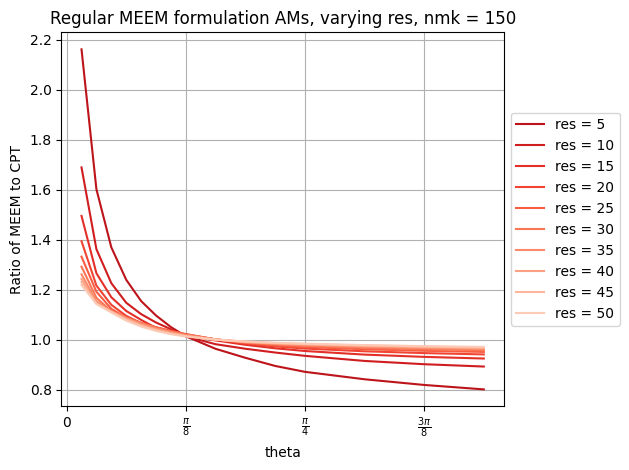

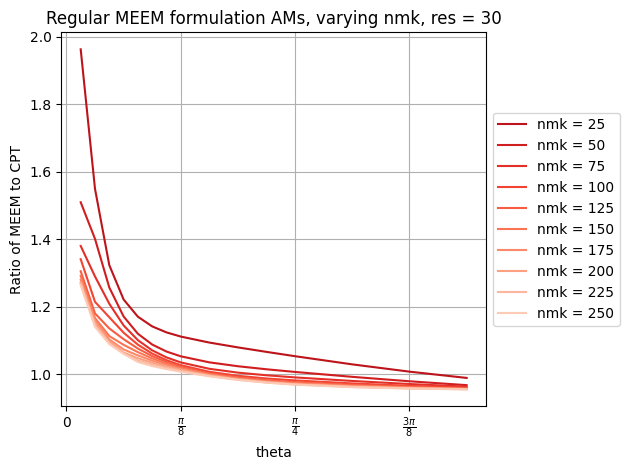

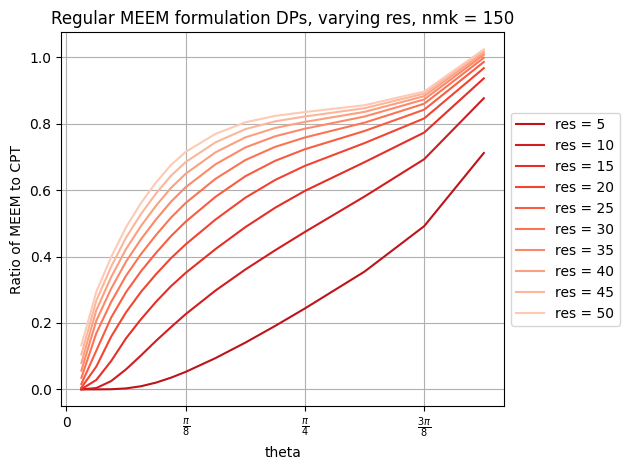

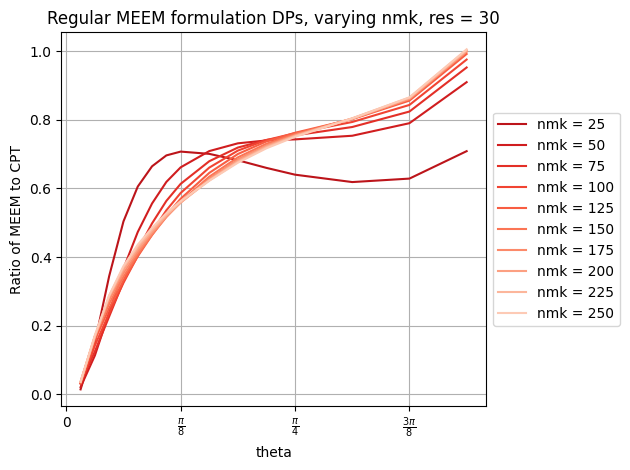

In [25]:
plot1(configurations, "AM", "res")
plot1(configurations, "AM", "nmk")
plot1(configurations, "DP", "res")
plot1(configurations, "DP", "nmk")

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_97574/1769443124.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cname)


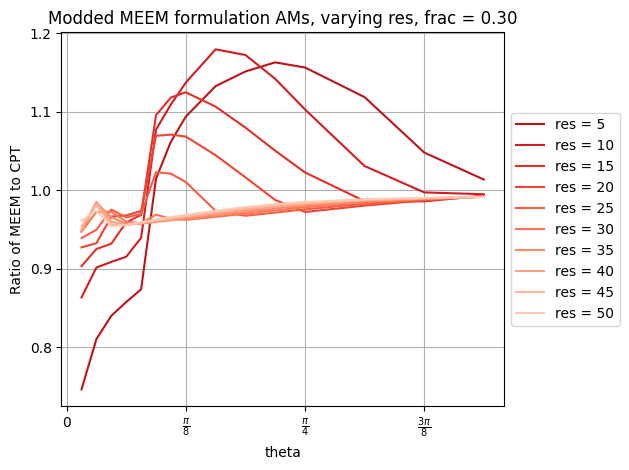

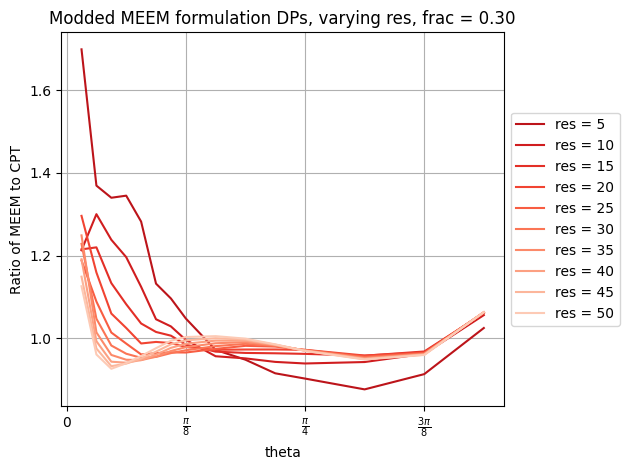

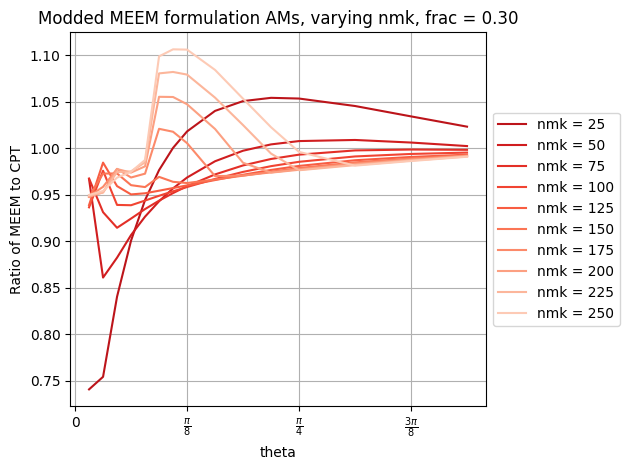

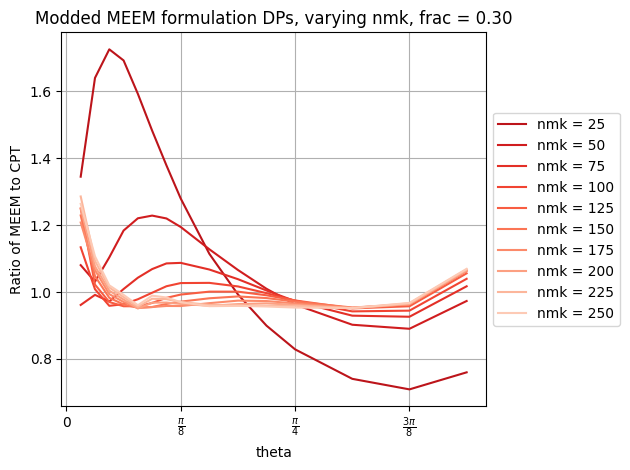

In [23]:
plot2(configurations, "AM", "res", 5)
plot2(configurations, "DP", "res", 5)
plot2(configurations, "AM", "nmk", 5)
plot2(configurations, "DP", "nmk", 5)

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_97574/1399085796.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cname)


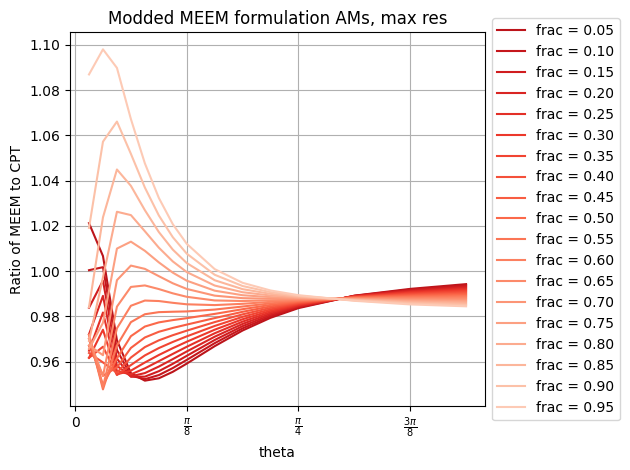

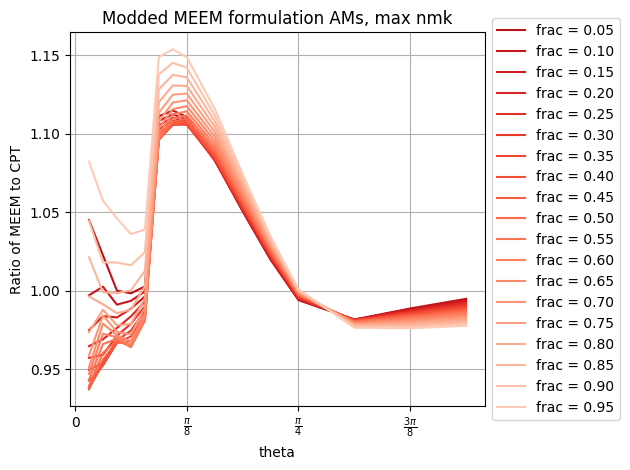

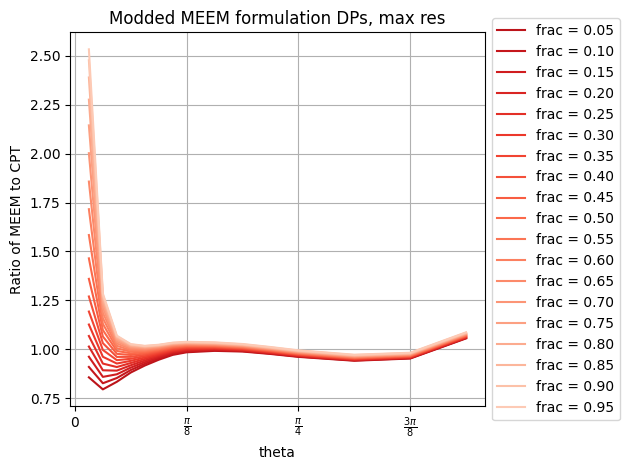

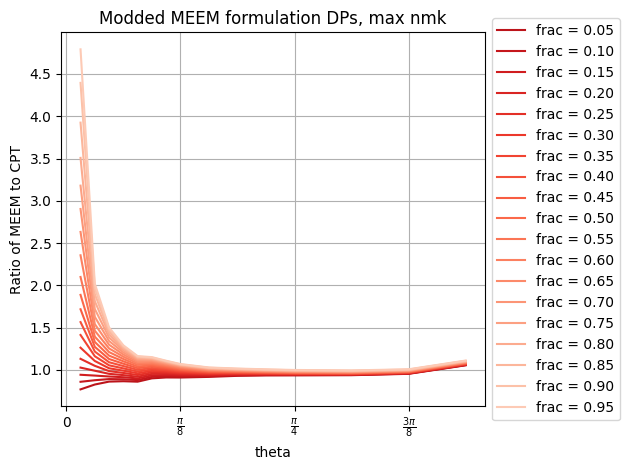

In [106]:
plot3(configurations, "AM", "res", -1)
plot3(configurations, "AM", "nmk", -1)
plot3(configurations, "DP", "res", -1)
plot3(configurations, "DP", "nmk", -1)

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_97574/1399085796.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cname)


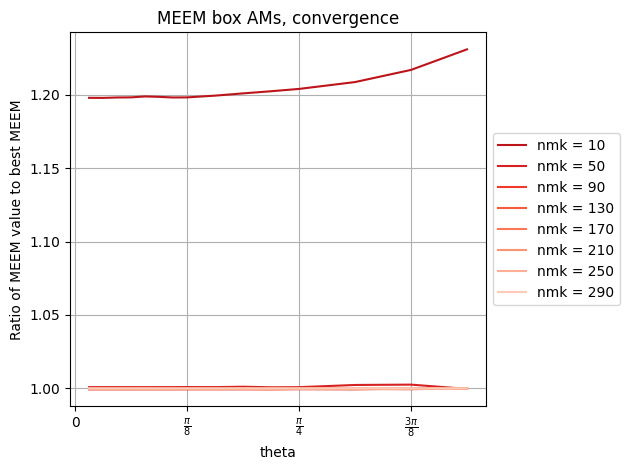

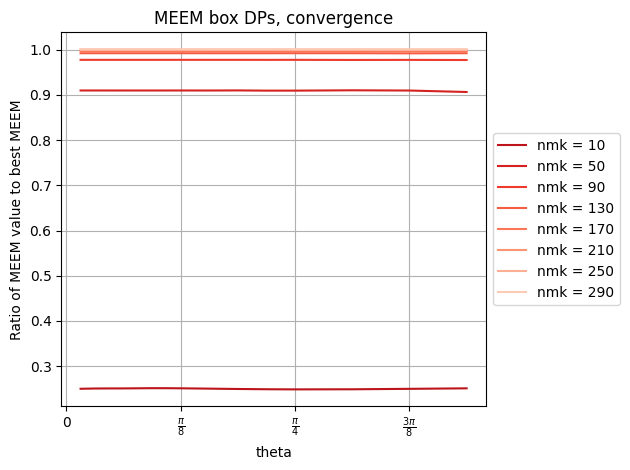

In [ ]:
plot4(configurations, "AM")
plot4(configurations, "DP")

# Note: NMK convergence for these is a lot better than for the slants.
# Still unsure if it's because of features relating to slants (very small delta-z or delta-r)
# Or because of features relating 

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_97574/3281317236.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("plasma")


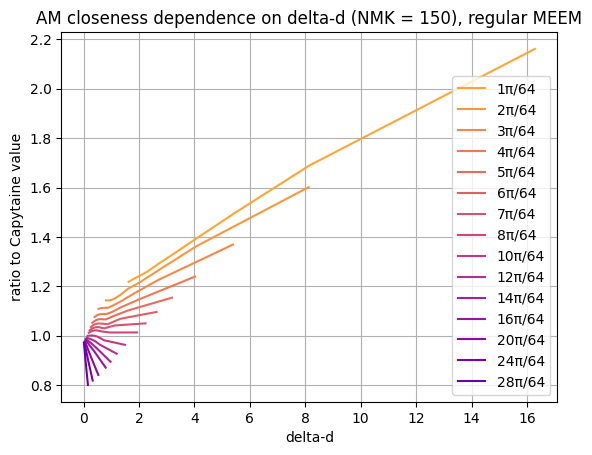

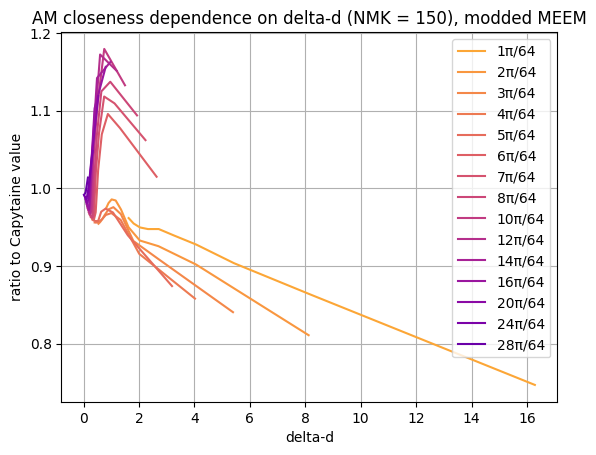

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_97574/3281317236.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = get_cmap("viridis")
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_97574/3281317236.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = get_cmap("magma")


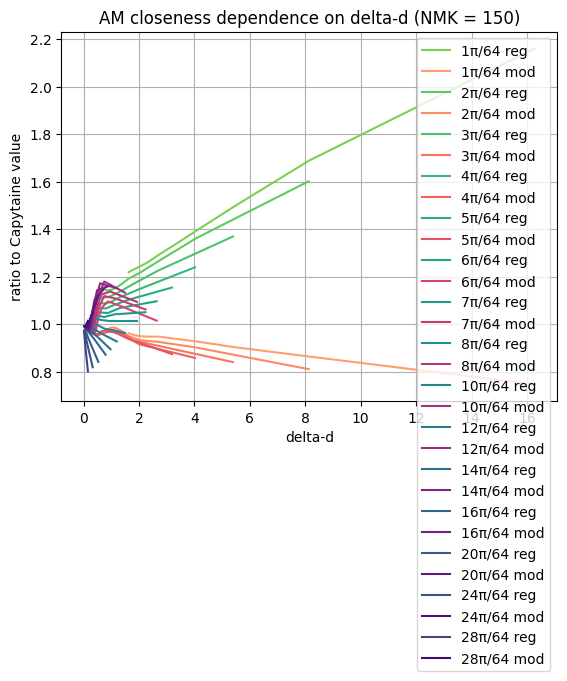

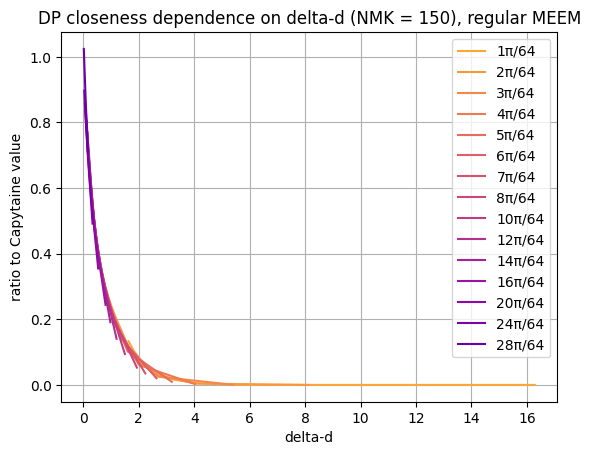

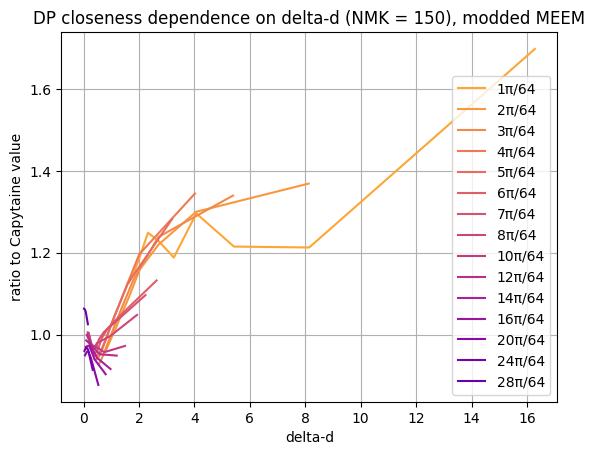

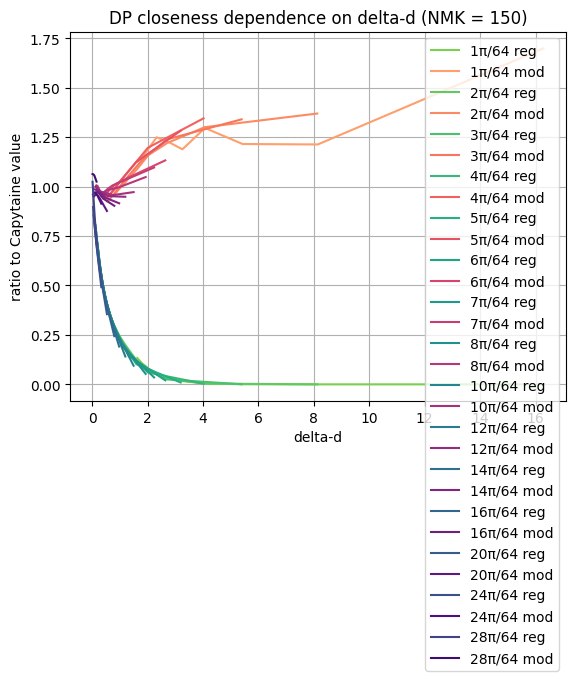

In [104]:
plot5(configurations, "AM", "regular")
plot5(configurations, "AM", "modded")
plot6(configurations, "AM")
plot5(configurations, "DP", "regular")
plot5(configurations, "DP", "modded")
plot6(configurations, "DP")